# **Finding Lane Lines on the Road** 
***
In this project, we will use the tools learned about in the lesson to identify lane lines on the road.  We will develop a pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images).

Ultimately, we would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  
Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

The tools we have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  

Our goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Our output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Our goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

#### Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  

Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.


In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


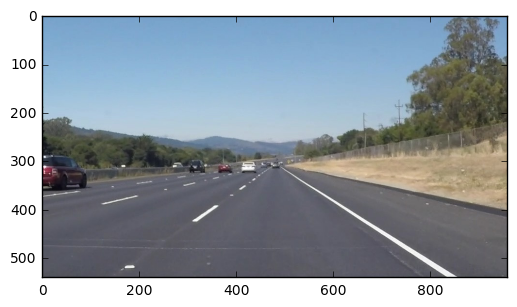

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
    """
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    """
    global previous_lane # get the x-coeffs of previously detected lane
    lefts = []  # keep all the left line edges detected
    rights = [] # keep the right line edges detected
    
    y_bottom = img.shape[0]          # start of left line, end of right line
    y_middle = int(img.shape[0]*.63) # end of left line, start of right line
    
    if lines is None:
        # use previously detected lane        
        cv2.line(img, (previous_lane[0], y_bottom), (previous_lane[1], y_middle), color, thickness)
        cv2.line(img, (previous_lane[2], y_middle), (previous_lane[3], y_bottom), color, thickness)
        return None
    
    m_left, m_right = [], [] # init avg line slopes
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = ((y2-y1)/(x2-x1)) # left lane slope neg, right lane pos
            
            if 0.5 < np.abs(slope) < 1.0: # filter the lines by slope size
                
                # show only left lines
                if slope < 0:
                    lefts.append([x1,y1,x2,y2])
                    m_left.append(slope)
                    
                # show only right lines
                if slope > 0:
                    rights.append([x1,y1,x2,y2])
                    m_right.append(slope)
    
    if len(lefts)==0 or len(rights)==0:
        # use previously detected lane
        cv2.line(img, (previous_lane[0], y_bottom), (previous_lane[1], y_middle), color, thickness)
        cv2.line(img, (previous_lane[2], y_middle), (previous_lane[3], y_bottom), color, thickness)
        return None
    
    # average the left and right line slopes
    slope_left = np.median(m_left)   # left line slope is neg
    slope_right = np.median(m_right) # right line slope is pos
    
    # average the left and right lines
    left_avg = np.mean(np.array(lefts), axis=0)
    right_avg = np.mean(np.array(rights), axis=0)
    
    x1_left, y1_left, x2_left, y2_left = left_avg.astype(np.int32)
    x1_right, y1_right, x2_right, y2_right = right_avg.astype(np.int32)
    
    # calculate avg intercept b, using b = y - m*x
    b_left = 0.5 * (y1_left - slope_left*x1_left + y2_left - slope_left*x2_left)
    b_right = 0.5 * (y1_right - slope_right*x1_right + y2_right - slope_right*x2_right)
    
    # create line from image bottom to top of ROI
    # x = (y - b)/m
    x2_left = ((y_middle - b_left)/slope_left).astype(np.int32)
    x2_right = ((y_bottom - b_right)/slope_right).astype(np.int32)
    
    x1_left = ((y_bottom - b_left)/slope_left).astype(np.int32)
    x1_right = ((y_middle - b_right)/slope_right).astype(np.int32)
    
    # use previous lane lines for smoothing
    if len(previous_lane) == 0:
        previous_lane = np.array([x1_left, x2_left, x1_right, x2_right])
    else:
        smooth = .75
        x1_left = (previous_lane[0]*smooth + x1_left*(1-smooth)).astype(np.int32)
        x2_left = (previous_lane[1]*smooth + x2_left*(1-smooth)).astype(np.int32)
        
        x1_right = (previous_lane[2]*smooth + x1_right*(1-smooth)).astype(np.int32)
        x2_right = (previous_lane[3]*smooth + x2_right*(1-smooth)).astype(np.int32)
    
    previous_lane = np.array([x1_left, x2_left, x1_right, x2_right]) # update prev lane
    
    cv2.line(img, (x1_left, y_bottom), (x2_left, y_middle), color, thickness)   # left
    cv2.line(img, (x1_right, y_middle), (x2_right, y_bottom), color, thickness) # right

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), 
                            minLineLength=min_line_len, 
                            maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now build the pipeline to work on the images in the directory "test_images"  

**Make sure the pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

Run the solution on all test_images (and make copies into the test_images directory, if desired).

In [5]:
def process_image(image):
    """
    Pipeline for lane line annotations
    """
    # keep image dimensions
    imshape = image.shape
    xsize = image.shape[1]
    ysize = image.shape[0]
    
    # convert to 0,255 bytescale
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

    # define kernel and apply smoothing
    kernel_size = 3
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
    
    # define parameters for Canny and apply
    low_threshold = 120
    high_threshold = 240
    edges = canny(blur_gray, low_threshold, high_threshold)
    
    # define four-sided polygon to mask and apply
    vertices = np.array([[(0,imshape[0]), 
                          (imshape[1]/2.1, imshape[0]*0.6), 
                          (imshape[1]/1.9, imshape[0]*0.6), 
                          (imshape[1],imshape[0])]], 
                        dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    
    # Define the Hough transform parameters
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 10 # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 100 # minimum number of pixels making up a line
    max_line_gap = 60 #minimum number of pixels making up a line

    return weighted_img(hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap), 
                        image, α=.6, β=1., λ=0.)

mkdir: test_images_results: File exists
solidWhiteCurve.jpg


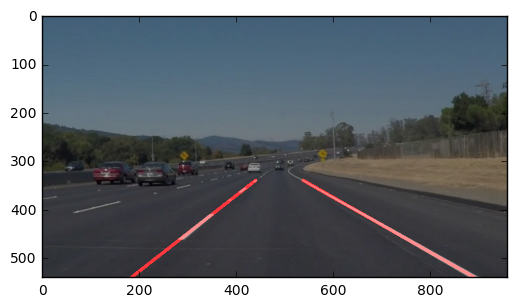

solidWhiteRight.jpg


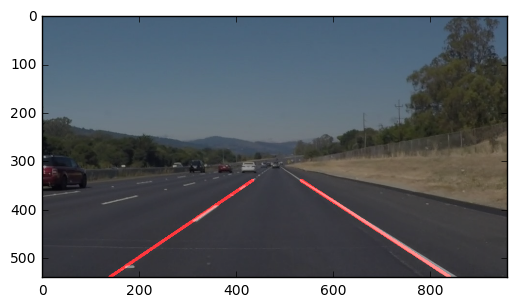

solidYellowCurve.jpg


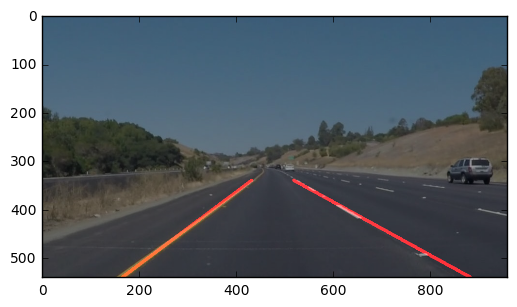

solidYellowCurve2.jpg


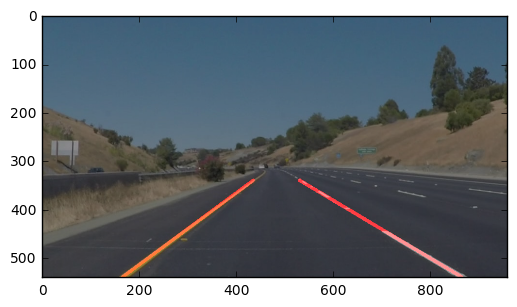

solidYellowLeft.jpg


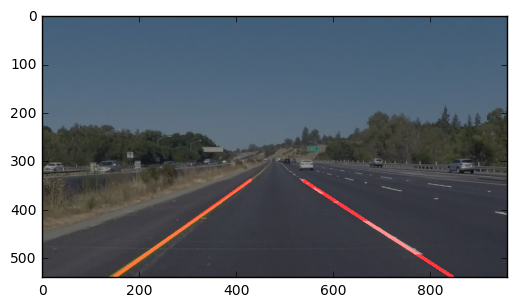

whiteCarLaneSwitch.jpg


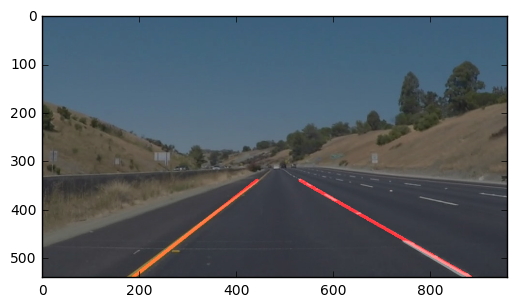

In [21]:
# DONE: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
% mkdir test_images_results

dirname = "test_images/"
for img in os.listdir(dirname):
    previous_lane = [] # init variable for lane line smoothing
    image = mpimg.imread(dirname+img)
    print(img)
    lines_edges = process_image(image)
    plt.imshow(lines_edges)
    plt.show()
    
    # uncomment below lines to save images
    #result = cv2.cvtColor(lines_edges, cv2.COLOR_BGR2RGB)
    #cv2.imwrite("test_images_results/" + img, result)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [9]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [10]:
previous_lane = [] # init variable for lane line smoothing

white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:07<00:00, 27.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 2.76 s, sys: 644 ms, total: 3.41 s
Wall time: 9 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [11]:
previous_lane = [] # init variable for lane line smoothing

yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:29<00:00, 23.19it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 8.7 s, sys: 3.24 s, total: 11.9 s
Wall time: 30.2 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [22]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:20<00:00, 12.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 5.16 s, sys: 1.67 s, total: 6.83 s
Wall time: 22.4 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))